In [5]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

%opts Layout [sublabel_format='' aspect_weight=1 figure_size=(100) vspace=0.4]
%output size = 150

randn = np.random.randn

alphas = np.linspace(0, 1, 1000)

dims = SimpleNamespace(E=holoviews.Dimension(r'$E$'),
                       alpha=holoviews.Dimension(r'$\alpha$'),
                       Q=holoviews.Dimension(r'$Q$'),
                       Q_BdG=holoviews.Dimension(r'$Q_{BdG}$'))

def make_random_real_ham(N):
    H = randn(N, N)
    H += H.T
    return H / 2


def make_cons_ham(N):
    H = np.kron(pauli.s0, randn(N, N)) + np.kron(pauli.sz, randn(N, N))
    H += H.T.conj()
    return H / 2


def make_random_ham(N):
    H = randn(N, N) + 1j * randn(N, N)
    H += H.T.conj()
    return H / 2


def make_random_symplectic_ham(N):
    if N % 2:
        raise ValueError('Matrix dimension should be a multiple of 2')
    sy = np.kron(np.eye(N // 2), np.array([[0, -1j], [1j, 0]]))
    h = randn(N, N) + 1j * randn(N, N)
    h += h.T.conj()
    Th = sy @ h.conj() @ sy
    return (h + Th) / 4


def make_chiral_ham(N):
    temp1 = randn(N, N) + 1j * randn(N, N)
    temp2 = randn(N, N) + 1j * randn(N, N)    
    H = np.kron(pauli.sx, temp1) + np.kron(pauli.sy, temp2)
    H += H.T.conj()
    return H / 2


def make_BdG_ham(N):
    # This is antisymmetric basis
    H = 1j * randn(2*N, 2*N)
    H += H.T.conj()
    return H / 2


def energies(alpha, H0, H1):
    H = (1 - alpha) * H0 + alpha * H1
    return np.linalg.eigvalsh(H)


def find_spectrum(alphas, H0, H1):
    spectrum = [energies(a, H0, H1) for a in alphas]
    return np.array(spectrum)


def find_Q(spectrum):
    """Finds the number of bands that are under zero energy.

    Parameters:
    -----------
    spectrum : numpy array
        Array that contains the energies levels for every alpha.

    Returns:
    --------
    Q : list
        Number of bands under zero energy.
    """
    return [len(s[s<0]) for s in spectrum]


def plot_hamiltonian_spectrum(alphas, spectrum, E_range=(-4, 4)):
    """Function that plots a spectrum for a range of alphas.

    Parameters:
    -----------
    alphas : numpy array
        Range of alphas for which the energies are calculated.
    spectrum : numpy array
        Array that contains the energies levels for every alpha.
    E_range : tuple
        The upper and lower limit of the y-dimension.

    Returns:
    --------
    plot : holoviews.Path object
        Plot of alphas vs. spectrum.
    """
    E_min, E_max = E_range
    plot = holoviews.Path((alphas, spectrum), kdims=[dims.alpha, dims.E])[:, E_min:E_max] * holoviews.HLine(0)
    return plot(plot={'xticks':[0, 0.5, 1], 'yticks':[E_min, 0, E_max]})


def plot_Q(alphas, Q, Q_range, Q_dim=dims.Q):
    """Function that plots value of Q for a range of alphas.

    Parameters:
    -----------
    alphas : numpy array
        Range of alphas for which the energies are calculated.
    Q : numpy array
        Vector that contains the value of Q for every alpha.
    Q_range : tuple
        The upper and lower limit of the y-dimension.

    Returns:
    --------
    plot : holoviews.Path object
        Plot of alphas vs. Q.
    """
    Q_min, Q_max = Q_range
    Q_mid = (Q_max + Q_min) / 2
    plot = holoviews.Area((alphas, Q), kdims=[dims.alpha], vdims=[Q_dim])[:, Q_min:Q_max](style={'alpha': 0.4})
    plot *= holoviews.Curve((alphas, Q), kdims=[dims.alpha], vdims=[Q_dim])[:, Q_min:Q_max]
    return plot(plot={'xticks':[0, 0.5, 1], 'yticks':[Q_min, Q_mid, Q_max], 'aspect':4})

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex, plt, pf, display_html
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli
Using kwant 1.3.2 and holoviews 1.9.5
Executed on 2018-03-12 at 17:48:38.216495.


# Topology and symmetry

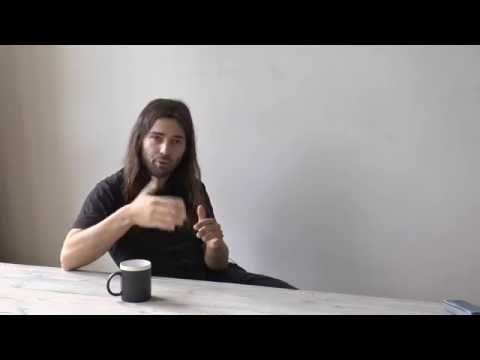

In [6]:
MoocVideo("5ysdSoorJz4", src_location='1.1-intro')

# Zero-dimensional quantum systems

Imagine a quantum system with a finite number of states $N$. The Hamiltonian of such a system is represented by a matrix $H$ of dimension $N\times N$.
This matrix is Hermitian, $H=H^\dagger$. Its real eigenvalues $E_n$ correspond to the allowed energies of the system,

$$H\,\left|n\right\rangle = E_n\,\left|n\right\rangle\,,$$

with $\left|n\right\rangle$ the corresponding eigenstate. Let's say that $H$ describes a small quantum dot with a few levels. We can imagine that the quantum dot is in weak contact with a metallic lead, as in the following sketch:


![](figures/dot.svg)


The presence of a metallic lead allows us to measure all the energies $E_n$ of the electronic states in the dot with respect to the Fermi level $E_F$ of the electrons in the metallic lead. In the following we will set $E_F=0$. Hence, all negative energies $E_n<0$ correspond to filled states in the dot, and all positive energies $E_n>0$ to empty states. In the sketch, the lead and the dot are separated by a potential barrier, such that they are only coupled very weakly. Thus, we can still consider the dot as an isolated system, to a good approximation.


We are now ready to start on the main theme of this course, topology.

## Topology and gapped quantum systems

Topology studies whether objects can be transformed continuously into each other. In condensed matter physics we can ask whether the Hamiltonians of two quantum systems can be continuously transformed into each other. If that is the case, then we can say that two systems are 'topologically equivalent'.

If we considered all Hamiltonians without any constraint, every Hamiltonian could be continuously deformed into every other Hamiltonian, and all quantum systems would be topologically equivalent. This changes drastically if we restrict ourselves to systems with an energy gap. This means that there is a finite energy cost to excite the system above its ground state.
If an energy gap is present, then the Hamiltonian of the system has no eigenvalues in a finite interval around zero energy.

We can now use the following criterion: we say that two gapped quantum systems are topologically equivalent if their Hamiltonians can be continuously deformed into each other *without ever closing the energy gap*.

In the following, we will see that often one is interested in some more specific criterion: for instance, that some symmetry may be preserved throughout the continuous path which connects two Hamiltonians.

However, for the moment let's just see these ideas at play using our quantum dot as a simple test case. Imagine our dot is initially described by a random $H$, such as:

In [7]:
np.random.seed(30)
H0 = make_random_real_ham(N=4)
pprint_matrix(H0)

For simplicity, we have taken $H$ to be real. Let's now deform this Hamiltonian into another Hamiltonian $H'$, also real. We can imagine that this deformation describes the changes that occur to the dot as an external parameter, such as a gate voltage, is varied. We can parameterize the deformation by

$H(\alpha) = \alpha H' + (1-\alpha) H,$

so that at $\alpha=0$ we are at the initial Hamiltonian and at $\alpha=1$ we are at the final Hamiltonian. Let's see what the energy levels do as a function of $\alpha$ (we use more levels here than in the matrix above so that the spectrum looks more interesting).

In [10]:
holoviews.plotting.mpl.MPLPlot.fig_rcparams['text.usetex'] = False
np.random.seed(69)   
H0 = make_random_real_ham(N=10)
H1 = make_random_real_ham(N=10)
spectrum = find_spectrum(alphas, H0, H1)
plot_hamiltonian_spectrum(alphas, spectrum)

:Overlay
   .Path.I  :Path   [$\alpha$,$E$]
   .HLine.I :HLine   [x,y]

You may notice from the plot that as $\alpha$ varies, it can happen that an energy level crosses zero energy. When this happens, we break the condition that there should be an energy gap in the system. Notice, however, that this does not necessarily mean that there is no continuous transformation between $H$ and $H'$ such that the gap does not close. It simply means that this particular path has gap closings. Perhaps it is possible to find another path which does not.

So are $H$ and $H'$ topologically equivalent or not? Let's look at this situation:

In [11]:
np.random.seed(6)
H0 = make_random_real_ham(N=10)
H1 = make_random_real_ham(N=10)
spectrum = find_spectrum(alphas, H0, H1)
plot_hamiltonian_spectrum(alphas, spectrum)

:Overlay
   .Path.I  :Path   [$\alpha$,$E$]
   .HLine.I :HLine   [x,y]

We see that one level does cross zero (even twice), but it seems obvious that we can just push it down a little bit and we find a continuous path between two Hamiltonians. So we need to come up with an easier way to figure out if Hamiltonians can be transformed into each other or not.

# The concept of a topological invariant

In order to know whether there is any path which connects $H$ and $H'$ without closing the gap, we can count the number of levels below zero energy, i.e. the number of filled energy levels. This is possible because the eigenvalues of gapped Hamiltonians can move freely as long as they don't cross zero energy. Therefore continuous transformations exist exactly between Hamiltonians with the same number of energy levels below zero.

Since this number can not change under continuous transformations inside the set of gapped Hamiltonians, we call it a *topological invariant* $Q$.

Below, we plot the energy levels along our path from $H$ to $H'$ again, together with our topological invariant, the number of filled energy levels. You can see that this number changes between 3, 4 and 5. Hence we can say that $H$ and $H'$ are not topologically equivalent.

In [12]:
np.random.seed(69)   
H0 = make_random_real_ham(N=10)
H1 = make_random_real_ham(N=10) 
spectrum = find_spectrum(alphas, H0, H1)
Q = find_Q(spectrum)
(plot_hamiltonian_spectrum(alphas, spectrum) + plot_Q(alphas, Q, [2, 6])).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q$)
      .Curve.I :Curve   [$\alpha$]   ($Q$)

The plot makes it clear that we do not actually have to count the number of filled energy levels for both $H$ and $H'$, so it is enough to keep track of *zero energy crossings*. Whenever an energy level crosses zero energy, the number of levels below zero energy changes. Such a crossing therefore changes the topological invariant. We call that a *topological phase transition*.

If two Hamiltonians have a different topological invariant, they must be separated by such a transition. In other words, it is impossible to go from one to the other without closing the gap.

On the other hand, if there are equally many levels crossing from below to above zero energy as the other way around, the number of levels below zero energy does not change. The topological invariant is therefore the same for the initial and final Hamiltonian. In this case, there must be a continuous transformation between the initial and final Hamiltonian which does not close the gap.

Once we have identified a topological invariant, we can *classify* all quantum Hamiltonians according to its value. In this way we create classes of Hamiltonians which are all topologically equivalent, and we can keep track of all the different *topological phases* that these Hamiltonians can support.

## Role of conservation laws

Let's now consider the case that the Hamiltonian of the quantum dot satisfies a symmetry constraint. This means that there is a unitary matrix, for example $U = \sigma_z \otimes 1\!\!1$ where $\sigma_z$ is the third Pauli matrix, such that the Hamiltonian commutes with this matrix:

$$U^\dagger H U = H.$$

This means that the system has a conservation law, and that the Hamiltonian can be brought to a block-diagonal form:

In [13]:
modes = 5
np.random.seed(10) 
H0 = make_cons_ham(2)
pprint_matrix(H0)

We can now look at the spectrum and the topological invariant of each subblock individually,

In [14]:
%%opts Layout [aspect_weight=1 fig_inches=(8, 6) fig_size=100 ]
np.random.seed(13) 
H0 = make_cons_ham(modes)
H1 = make_cons_ham(modes)
spectrum1 = find_spectrum(alphas, H0[:modes, :modes], H1[:modes, :modes])
spectrum2 = find_spectrum(alphas, H0[modes:, modes:], H1[modes:, modes:])
Q1 = find_Q(spectrum1)
Q2 = find_Q(spectrum2)
(plot_hamiltonian_spectrum(alphas, spectrum1, [-3, 3]) + plot_hamiltonian_spectrum(alphas, spectrum2, [-3, 3])
 + plot_Q(alphas, Q1, [0, 4]) + plot_Q(alphas, Q2, [0, 4])).cols(2)

:Layout
   .Overlay.I   :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.III :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q$)
      .Curve.I :Curve   [$\alpha$]   ($Q$)
   .Overlay.IV  :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q$)
      .Curve.I :Curve   [$\alpha$]   ($Q$)

and combine them to get the spectrum and the topological invariant of the whole system:

In [15]:
spectrum = find_spectrum(alphas, H0, H1)
Q = find_Q(spectrum)
(plot_hamiltonian_spectrum(alphas, spectrum) + plot_Q(alphas, Q, [3, 7])).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q$)
      .Curve.I :Curve   [$\alpha$]   ($Q$)

As you can see, unitary symmetries play a rather boring role. As usual, they allow to reduce the dimension of the problem at hand, but nothing more. There are however other symmetries which can have a rich influence on topology. An important example is time-reversal symmetry, as we will see next.

# Time-reversal symmetry

In our previous examples, you might have wondered, whether there was anything special with choosing real matrices? Indeed there was something special. A real Hamiltonian is a manifestation of time-reversal symmetry. Time-reversal symmetry is represented by an anti-unitary operator, and as such it can always be written as the product $\mathcal{T}=U\mathcal{K}$ of a unitary matrix times complex conjugation. In the case above, we had simply $\mathcal{T}\equiv\mathcal{K}$. Our real Hamiltonians clearly obeyed time-reversal symmetry since $H=H^*$.

Let's now break time-reversal symmetry, create random Hamiltonians with complex entries and see what happens.

In [16]:
np.random.seed(91)   
H0 = make_random_ham(N=4)
pprint_matrix(H0)

In [17]:
np.random.seed(92)   
H0 = make_random_ham(N=10)
H1 = make_random_ham(N=10) 
spectrum = find_spectrum(alphas, H0, H1)
Q = find_Q(spectrum)
(plot_hamiltonian_spectrum(alphas, spectrum) + plot_Q(alphas, Q, [3, 7])).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q$)
      .Curve.I :Curve   [$\alpha$]   ($Q$)

As you can see, there aren't really many differences with the previous case. The different energy levels move, and the topological invariant changes when one of them crosses zero.

There is, however, a very important case where time-reversal symmetry makes a real difference. For systems with spin $1/2$, time-reversal symmetry has the operator

$$
\mathcal{T}=i\sigma_y \mathcal{K},
$$

with $\sigma_y$ the second Pauli matrix acting on the spin degree of freedom. In that case $\mathcal{T}^2=-1$. A Hamiltonian with this type of time-reversal symmetry obeys the equation

$$
H = \sigma_y\, H^* \sigma_y.
$$

The following matrix is an example of such Hamiltonian:

In [18]:
np.random.seed(49) 
H0 = make_random_symplectic_ham(N=4)
pprint_matrix(H0)

Hamiltonians of this type have the following property: every energy eigenvalue $E_n$ is doubly degenerate (Kramers' degeneracy). We can see the consequences of Kramers' degeneracy on our game of deforming one random Hamiltonian into another.

In [19]:
np.random.seed(2285)   
H0 = make_random_symplectic_ham(N=10)
H1 = make_random_symplectic_ham(N=10) 
spectrum = find_spectrum(alphas, H0, H1)
Q = find_Q(spectrum)
(plot_hamiltonian_spectrum(alphas, spectrum) + plot_Q(alphas, Q, [3, 7])).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q$)
      .Curve.I :Curve   [$\alpha$]   ($Q$)

While the spectrum looks quite similar to the previous ones, whenever a line crosses zero energy, our topological invariant makes a jump of two, and not one! In this case, time-reversal symmetry constrains the topological invariant to only take even values. This is an example of how topological properties can be influenced by discrete symmetries.

# Sublattice symmetry

We just saw that time-reversal symmetry can forbid the topological invariant to take a certain set of values. We now study another case where a symmetry changes the topological properties dramatically. 

Let's now take a system where we can split all the degrees of freedom into two groups (say group $A$ and group $B$) such that the Hamiltonian only has nonzero matrix elements between two groups, and not inside each group. This situation arises naturally when the lattice has two sublattices, as in the hexagonal carbon lattice of graphene. So let's imagine our quantum dot is now a graphene dot:

![](figures/graphene_dot.svg)

As a consequence of sublattice symmetry, the Hamiltonian of the graphene dot looks like this:

$$
H =
\begin{pmatrix}
0 & H_{AB} \\
H_{AB}^\dagger & 0
\end{pmatrix}.
$$

We can once again generate a random Hamiltonian with sublattice symmetry, here:

In [20]:
np.random.seed(98)
pprint_matrix(make_chiral_ham(2))

If we introduce a diagonal matrix $\sigma_z$ that equals $+1$ for sites on sublattice $A$, and $-1$ for sites on sublattice $B$, we can write the sublattice symmetry of the Hamiltonian as

$$
\sigma_z H \sigma_z = -H.
$$

This immediately means that if $(\psi_A, \psi_B)^T$ is an eigenvector of the Hamiltonian with energy $\varepsilon$, then
$(\psi_A, -\psi_B)^T$ is an eigenvector with energy $-\varepsilon$. A symmetric spectrum is the consequence of sublattice symmetry.

What does this mean for the topological classification?
Clearly, the number of states with negative energy is the same as the number of states with positive energy, and that means we don't ever expect a single level to cross zero energy.

Let's once again see if this is correct by transforming a random Hamiltonian with sublattice symmetry into another one.

In [21]:
modes = 10
np.random.seed(99) 
H0 = make_chiral_ham(modes)
H1 = make_chiral_ham(modes)
spectrum = find_spectrum(alphas, H0, H1)
plot_hamiltonian_spectrum(alphas, spectrum, [-3, 3])

:Overlay
   .Path.I  :Path   [$\alpha$,$E$]
   .HLine.I :HLine   [x,y]

Indeed, we can deform all the Hamiltonians with sublattice symmetry into one another without closing the gap.
This means that an extra symmetry may render topological classification trivial. 

In [22]:
question = ("OK, let's see what we have so far. Which symmetry certainly "
            "does not restrict the values that the topological invariant can take?")

answers = ["Spinless time-reversal symmetry", "Sublattice symmetry", "Conservation law", "Spinful time-reversal symmetry"]

explanation = ("We cannot be sure about the conservation law, since the blocks may have different remaining symmetries. "
               "And we just saw that sublattice symmetry makes every system trivial, while spinful time-reversal "
               "makes the numbers of levels even.")

MoocMultipleChoiceAssessment(question, answers, correct_answer=0, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'We cannot be sure about the conservation law, since the blocks may have different remaining symmetries. And we just saw that sublattice symmetry makes every system trivial, while spinful time-reversal makes the numbers of levels even.', 'display_name': 'Question', 'max_attempts': 2, 'correct_answer': 0, 'answers': ['Spinless time-reversal symmetry', 'Sublattice symmetry', 'Conservation law', 'Spinful time-reversal symmetry'], 'question': "OK, let's see what we have so far. Which symmetry certainly does not restrict the values that the topological invariant can take?"})

# Particle-hole symmetry

There is another symmetry that has a strong influence on topology: particle-hole symmetry. It shows up in superconducting systems. As an example, imagine bringing our quantum dot in contact with a superconductor, like this:

![](figures/SCdot.svg)

A superconductor will create and annihilate pairs of electrons by breaking apart [Cooper pairs](https://en.wikipedia.org/wiki/Cooper_pair) and forming them.
This results in a Hamiltonian:

$$
\mathcal{H} = \sum_{nm} H_{nm} c^\dagger_nc_m + \tfrac{1}{2} (\Delta_{nm} c^\dagger_n c^\dagger_m + \Delta^*_{nm} c_m c_n),
$$

where $c^\dagger_n, c_n$ are the creation and annihilation operators of the electrons. We recall that these operators anticommute, obeying the relations $c_nc_m+c_mc_n=0$ and $c^\dagger_n c_m + c_m c^\dagger_n = \delta_{mn}$, where $\delta_{mn}=0$ if $m\neq n$ and $1$ if $m=n$.

The $H$-term is the dynamics of the electrons in the dot, while $\Delta$ describes the pair creation and annihilation. The matrix $\Delta$ is antisymmetric because the fermion operators anticommute. Now $\mathcal{H}$ does not conserve the number of electrons, but still conserves the parity of the number of electrons, that is whether the number of electrons is even or odd. We can now group all the creation and annihilation operators in a vector, $C = (c_1, \dots, c_n, c^\dagger_1, \dots, c^\dagger_n)^T$. Then we write $\mathcal{H}$ in the form 'row multiplies matrix multiplies column':

$$
\mathcal{H} = \frac{1}{2} C^\dagger H_\textrm{BdG}\,C\,.
$$

The matrix $H_\textrm{BdG}$ is known as the Bogoliubov-de Gennes Hamiltonian, and it has the following structure:

$$
H_\textrm{BdG} = \begin{pmatrix} H & \Delta \\ -\Delta^* & -H^* \end{pmatrix}.
$$

The Bogoliubov-de Gennes Hamiltonian acts on wave functions whose first half is composed out of annihilation operators of electrons, and the second half out of creations operators of the same electrons.
We can think of them as annihilation operators of an extra set of holes, so that we double the amount of degrees of freedom in the system.

Since holes are related to the electrons, $H_{BdG}$ automatically has an extra symmetry.
This symmetry exchanges electrons with holes, and has an antiunitary operator $\mathcal{P}=\tau_x \mathcal{K}$, where the Pauli matrix $\tau_x$ acts on the particle and hole blocks. We have that:

$$
\mathcal{P} H_\textrm{BdG} \mathcal{P}^{-1} = -H_\textrm{BdG}.
$$

Particle-hole symmetry is represented by an anti-unitary operator which anti-commutes with the Hamiltonian (compare this situation with that of time-reversal and sublattice symmetries). Because of the minus sign in the particle-hole symmetry, the spectrum of $H_\textrm{BdG}$ must be symmetric around zero energy (that is, the Fermi level). Indeed, for every eigenvector $\psi = (u, v)^T$ of $H_\textrm{BdG}$ with energy $E$, there will be a particle-hole symmetric eigenvector $\mathcal{P}\psi=(v^*, u^*)^T$ with energy $-E$.

## Fermi level crossings in a random Bogoliubov-de Gennes Hamiltonian

Let's generate a random Bogoliubov-de Gennes Hamiltonian $H_\textrm{BdG}$:

In [38]:
modes = 4
np.random.seed(11) 
H0 = make_BdG_ham(modes)
H1 = make_BdG_ham(modes)

#Print in 'normal' basis
H0_normal = np.kron(np.array([[1, -1j],[1, 1j]]), np.identity(modes)) @ H0
H0_normal = H0_normal @ np.kron(np.array([[1, 1],[1j, -1j]]), np.identity(modes))


H1_normal = np.kron(np.array([[1, -1j],[1, 1j]]), np.identity(modes)) @ H1
H1_normal = H1_normal @ np.kron(np.array([[1, 1],[1j, -1j]]), np.identity(modes))
spectrum_normal = find_spectrum(alphas, H0_normal, H1_normal)
spectrum = find_spectrum(alphas, H0, H1)

(plot_hamiltonian_spectrum(alphas, spectrum_normal, [-6, 6]) + plot_hamiltonian_spectrum(alphas, spectrum, [-3, 3]) ).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]

In [23]:
modes = 2
np.random.seed(101) 
H0 = make_BdG_ham(modes)
H1 = make_BdG_ham(modes)

#Print in 'normal' basis
H0_normal = np.kron(np.array([[1, -1j],[1, 1j]]), np.identity(modes)) @ H0
H0_normal = H0_normal @ np.kron(np.array([[1, 1],[1j, -1j]]), np.identity(modes))
pprint_matrix(H0_normal)

We can now see what happens when we deform it into a second one. You can indeed see clearly that the spectrum is mirrored around the line $E=0$, just like it was in the presence of sublattice symmetry.

In [39]:
modes = 10
np.random.seed(5)
H0 = make_BdG_ham(modes)
H1 = make_BdG_ham(modes)
spectrum = find_spectrum(alphas, H0, H1)
plot_hamiltonian_spectrum(alphas, spectrum, [-3, 3])

:Overlay
   .Path.I  :Path   [$\alpha$,$E$]
   .HLine.I :HLine   [x,y]

You can however notice that, unlike in the case of sublattice symmetry, energy levels do not repel around zero energy, so that crossings at zero energy appear.

## Fermion parity switches

Let's think a bit more about these crossings. At first, they might look a bit mysterious. In general a crossing between energy levels happens in the presence of a conserved quantity, and our random Bogoliubov-de Gennes Hamiltonian does not seem to have an obvious one. Let's however recall what we said earlier: While the mean-field Hamiltonian of a superconductor does not conserve the number of particles, it conserves the parity of this number. In other words, forming and breaking Cooper pairs does not affect whether the superconducting quantum dots contains an even or odd number of electrons. In short, fermion parity is a conserved quantity (provided that isolated electrons do not enter or leave the dot, a possibility which we will disregard).

The above observation reveals that the existence of crossings is due to the fermion parity conservation. Fermion parity, however, is a many-body quantity, which cannot be directly described in terms of the single particle picture of the Bogoliubov-de Gennes Hamiltonian. 
To understand the existence of the crossings, recall that to obtain a Bogoliubov-de Gennes description of the superconductor we had to double the number of degrees of freedom by introducing holes.
Hence, unlike in the case of sublattice symmetry, a pair of $\pm E$ energy levels does not corresponds to two distinct quantum states, but to a *single* quantum state.
This quantum state is a coherent superposition of electrons and holes - a *Bogoliubov quasiparticle*: it has an excitation energy $E$, and it is created by an operator $a^\dagger = u c^\dagger + v c$.
Populating the partner state at energy $-E$ is the same as emptying the positive energy state.

When a pair of levels crosses zero energy, the excitation energy $E$ of the Bogoliubov quasiparticle changes sign and it becomes favorable to add a Bogoliubov quasiparticle to, or remove it from the superconducting quantum dot. In other words, at each crossing the fermion parity in the ground state of the dot changes from even to odd, or vice versa. Hence these crossings are *fermion parity switches*.

Since the ground state fermion parity is preserved by the superconducting Hamiltonian if there are no Bogoliubov quasiparticles crossing zero energy, the ground state fermion parity is the topological invariant of this system. It is clear however that this invariant is of a different nature than the one of the non-superconducting systems, which is given by the number of negative eigenvalues of the Hamiltonian. The latter cannot change for a Bogoliubov-de Gennes Hamiltonian, which has a symmetric energy spectrum, and hence it is not suitable to describe changes in fermion parity. Is there a way to compute this new invariant directly from the Bogoliubov-de Gennes Hamiltonian?

## The Pfaffian invariant

In order to introduce the new invariant, we have to start with a basis transformation, that makes the Hamiltonian an antisymmetric matrix. We use the following unitary transformation in particle-hole space,

$$
\tilde{H}_{BdG}=\frac{1}{2}\left( \begin{array}{cc}
1 & 1 \\
i & -i \end{array} \right) 
H_{BdG} 
\left( \begin{array}{cc}
1 & -i \\
1 & i \end{array} \right)\,.
$$

We then have

$$
\tilde{H}_\textrm{BdG} = \frac{1}{2}\begin{pmatrix} H-H^*+\Delta-\Delta^* & -iH-iH^*+i\Delta+i\Delta^* \\ +iH+iH^*+i\Delta+i\Delta^* & H-H^*-\Delta+\Delta^* \end{pmatrix}.
$$

We already know that the pairing matrix $\Delta$ is antisymmetric. Since $H$ is Hermitian $H-H^*$ is also antisymmetric and $H+H^*$ is symmetric. Then we can see that $\tilde{H}_\textrm{BdG}$ is antisymmetric.

There is a special number that we can compute for antisymmetric matrices, the [Pfaffian](http://en.wikipedia.org/wiki/Pfaffian). Its rigorous definition is not important for our course. The basic idea is simple: The eigenvalues of antisymmetric matrices always come in pairs. In the case of our $\tilde{H}_{BdG}$, these are the energy eigenvalues $\pm E_n$. By taking their product we obtain the determinant of the matrix, equal to $\prod_n (-E_n^2)$. The key property of the Pfaffian is that it allows to take a square root of the determinant, equal to $\pm i\prod_n E_n$, in such a way that the sign of the product is uniquely defined. At a fermion parity switch a single $E_n$ changes sign, so the Pfaffian changes sign as well (while the determinant stays the same).

This feature of the Pfaffian really makes it what we are looking for. Let's try out the sign of the Pfaffian as our topological invariant $Q_\textrm{BdG}$:

$$ Q_\textrm{BdG} = \textrm{sign}\left[\,\textrm{Pf} (i H_\textrm{BdG})\,\right]\,.$$

We have included a factor of $i$ just for convenience, so that the Pfaffian is a real number.

Whenever we need to compute a Pfaffian we just use the [Pfapack](http://arxiv.org/abs/1102.3440) package that calculates Pfaffians for numerical matrices. Let's use that package and check that the Pfaffian indeed allows us to calculate the fermion parity of the ground state of $H_\textrm{BdG}$.

In [40]:
%%opts Overlay [yticks=[-1, 0, 1]]

def find_pfaffian(alphas, H0, H1):
    """Function caculates the Pfaffian for a Hamiltonian.

    Parameters:
    -----------
    alphas : numpy array
        Range of alphas for which the energies are calculated.
    H0 : numpy array
        Hamiltonian, same size as H1.
    H1 : numpy array
        Hamiltonian, same size as H0.
        
    Returns:
    --------
    pfaffians : numpy array
        Pfaffians for each alpha.
    """
    def H(alpha):
        return (1 - alpha) * H0 + alpha * H1
    pfaffians = [np.sign(np.real(pf.pfaffian(1j*H(a)))) for a in alphas]
    return np.array(pfaffians)

pfaffian = find_pfaffian(alphas, H0, H1)
(plot_hamiltonian_spectrum(alphas, spectrum, [-1.5, 1.5]) + plot_Q(alphas, pfaffian, [-1.5, 1.5], dims.Q_BdG)).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Path.I  :Path   [$\alpha$,$E$]
      .HLine.I :HLine   [x,y]
   .Overlay.II :Overlay
      .Area.I  :Area   [$\alpha$]   ($Q_{BdG}$)
      .Curve.I :Curve   [$\alpha$]   ($Q_{BdG}$)

You can see how the Pfaffian invariant $Q_\textrm{BdG}$ changes its value from $+1$ to $-1$ at every zero-energy crossing. 
This means that it is the correct expression for the ground state fermion parity and for the topological invariant.

In [ ]:
question = ("What happens to the topological invariant if we take the superconducting" +
                              " Hamiltonian and set $\Delta=0$?")
answers = ["The Pfaffian invariant still captures all of the topological properties.",
           "The Hamiltonian loses particle-hole symmetry and becomes topologically trivial.",
           "The Hamiltonian now has a new conservation law so there are two blocks, each with its own invariant.",
           "It isn't allowed to set $\Delta=0$"]
explanation = ("If $\Delta=0$ the numbers of filled electron and hole states is conserved, and so the invariant once again"
               " becomes just the number of filled states.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=2, explanation=explanation)

# Conclusion

In [ ]:
MoocVideo("C7HoXjVbpoM", src_location='1.1-summary')

**Questions about what you learned? Ask them below**

In [ ]:
MoocDiscussion('Questions', 'Hamiltonians, Topology and Symmetry')